# VSE CA1 Part1

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import glob
import os
import urllib.request
import shutil

from scipy.special import expit #sigmoid
from imgaug import BoundingBox, BoundingBoxesOnImage
import imgaug as ia

from YOLO_API import YoloV3_API, BoundingBox, calculate_bb_iou

Using TensorFlow backend.


In [2]:
# Download YOLOV3 Pretrained Weights
url = 'https://drive.google.com/file/d/1Y0E928LRsa1qmP_5P8jHfzSbI8A9T2Pb/view?usp=sharing'
with urllib.request.urlopen(url) as response, open('Yolov3_pretrained_weights.h5', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

In [2]:
# Dataset directory
img_dir = "../data/image/"
anno_dir = "../data/annotation/"

In [3]:
# Construct YOLOv3 API object
yoloAPI = YoloV3_API(
    img_dir=img_dir,
    annotation_dir=anno_dir,
    saved_model_name='final_yolo_model_2.h5',
    train_size=0.8,
    height=416,
    width=416,
    threshold=0.5,
    batch_size=2)

Image directory: ../data/image/
Annotation directory: ../data/annotation/
Saved model name: final_yolo_model_2.h5
Train/validation size ratio: 0.8
Training size: 416x416
Threshold: 0.5
Batch Size: 2

All Image and annotation size: 765
Unique labels: dict_keys(['car', 'bus'])
Generated Anchor Boxes: [8, 10, 14, 18, 24, 26, 38, 32, 40, 52, 49, 107, 66, 43, 78, 73, 95, 117]

Training image and annotation size: 612
Validation image and annotation size: 153
Maximum bounding boxes in all images: 15

Train Generator created: To access, use <YoloV3_API.train_generator>
Validation Generator created: To access, use <YoloV3_API.valid_generator>

Loading pretrained weights
YOLOv3 Training Model created: To access, use <YoloV3_API.train_model>

YOLOv3 Inference Model created: To access, use <YoloV3_API.infer_model>

Train Model Summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     C

In [ ]:
%%time
history = yoloAPI.fit_generator(epoch=300, lr=1e-4)

In [5]:
#### Proto
inf_model = yoloAPI.infer_model
inf_model.load_weights('final_yolo_model_2.h5')

In [ ]:
imgpath = 'sunny2-001.jpeg'
boxes = yoloAPI.predict(imgpath)

In [6]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)//new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)//new_h
        new_h = net_h

    # resize the image to the new size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image/255., (new_w, new_h))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[(net_h-new_h)//2:(net_h+new_h)//2, (net_w-new_w)//2:(net_w+new_w)//2, :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

In [7]:
def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [8]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = expit(netout[..., :2])
    netout[..., 4]   = expit(netout[..., 4])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i // grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[row, col, b, 4]
            
            if(objectness <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[row,col,b,:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[row,col,b,5:]
            
            box = BoundingBox(xmin=x-w/2, ymin=y-h/2, xmax=x+w/2, ymax=y+h/2, objectiveness_score=objectness, classes=classes)

            boxes.append(box)

    return boxes

In [9]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [10]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if calculate_bb_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [11]:
### Read and resize image # Preprocess image


testimgpath = '..\data\Test_images'
file_types = ('\*.jpg', '\*.jpeg')
test_images = []
for files in file_types:
    test_images.extend(glob.glob(testimgpath+files))


    
img = cv2.imread(test_images[0])

input_img = preprocess_input(img, 416, 416)

# expected_height, expected_width, _ = img.shape
# net_h, net_w = 416,416
# if (float(416)/expected_width) < (float(net_h)/expected_height):
#     expected_height = (expected_height * net_w)//expected_width
#     expected_width = net_w
# else:
#     expected_width = (expected_width * net_h)//expected_height
#     expected_height = net_h

# print(str(expected_height) + ', ' + str(expected_width))

# img_resized = cv2.resize(img[:,:,::-1]/255, (416, 416))
# img_resized = img[:,:,::-1]/255

# print(img_resized.shape)
# new_img = np.ones((expected_height, expected_width, 3)) * 0.5
# new_img[(net_h-expected_height)//2:(net_h+expected_height)//2, (net_w-expected_width)//2:(net_w+expected_width)//2, :] = img_resized

# input_img = np.expand_dims(img_resized, 0) # Shape is now (1, 416, 416, 3)
input_img.shape

(1, 416, 416, 3)

In [12]:
# Actual prediction
pred = inf_model.predict(input_img)
print(f'Big Pred: {pred[0][0].shape}')
print(f'Mid Pred: {pred[1][0].shape}')
print(f'Small Pred: {pred[2][0].shape}')

Big Pred: (13, 13, 21)
Mid Pred: (26, 26, 21)
Small Pred: (52, 52, 21)


In [13]:
pred[0].shape

(1, 13, 13, 21)

In [14]:
boxes = []
for p in range(len(pred)):
    yolo_anchors = yoloAPI.anchor_boxes[(2-p)*6:(3-p)*6]
    print(yolo_anchors)
    boxes.append(decode_netout(pred[p][0], yolo_anchors, 0.5, 416, 416))

[66, 43, 78, 73, 95, 117]
[38, 32, 40, 52, 49, 107]
[8, 10, 14, 18, 24, 26]


In [15]:
# all_boxes = BoundingBoxesOnImage(boxes, (416, 416))''
# all_boxes.shape
# ia.imshow(all_boxes.draw_on_image(input_img)
img_h, img_w, _ = img.shape
flat_list = [item for sublist in boxes for item in sublist]
correct_yolo_boxes(flat_list, img_h, img_w, 416, 416)
do_nms(flat_list, 0.5)
# bbs_final = ia.BoundingBoxesOnImage(flat_list, (img_w, img_h))
len(flat_list)

7

In [16]:
str(flat_list[0])
# outimg = img
# for bb in flat_list:
#     cv2.rectangle(img=outimg, pt1=(bb.xmin, bb.ymin), pt2=(bb.xmax,bb.ymax), color=(0,0,255), thickness=1)
# cv2.imshow('img', outimg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

'xmin: -122, xmax: 130, ymin: -334, ymax: -217, label: None'

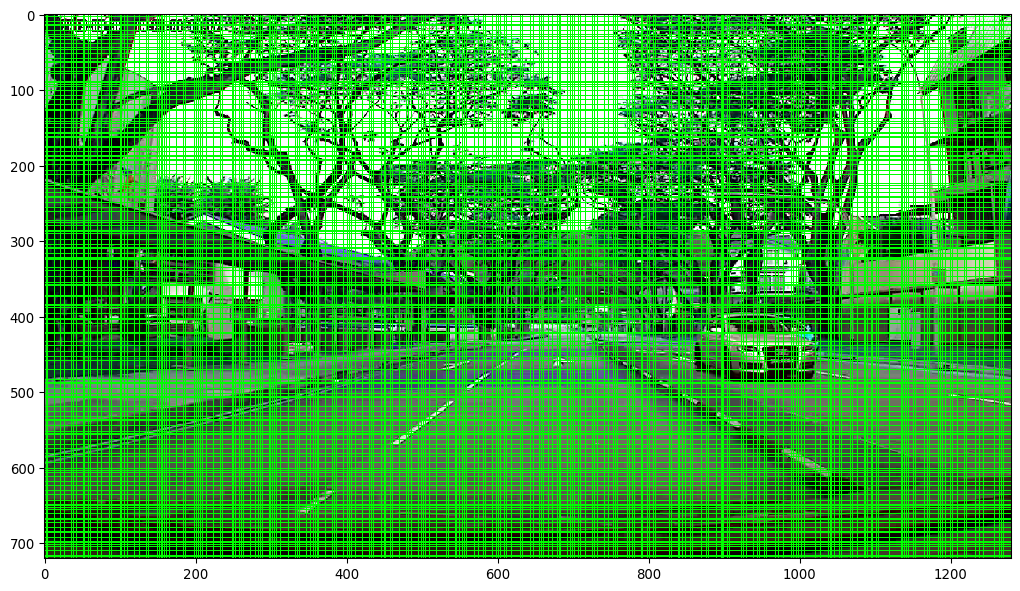

In [68]:
ia.imshow(bbs_final.draw_on_image(img))

In [32]:
def draw_boxes(image, boxes, labels, obj_thresh, quiet=True):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.label[i] > obj_thresh:
                if label_str != '': label_str += ', '
                label_str += (labels[i] + ' ' + str(round(box.get_score()*100, 2)) + '%')
                label = i
            if not quiet: print(label_str)
                
        if label >= 0:
            text_size = cv2.getTextSize(label_str, cv2.FONT_HERSHEY_SIMPLEX, 1.1e-3 * image.shape[0], 5)
            width, height = text_size[0][0], text_size[0][1]
            region = np.array([[box.x1-3,        box.y1], 
                               [box.x1-3,        box.y1-height-26], 
                               [box.x1+width+13, box.y1-height-26], 
                               [box.x1+width+13, box.y1]], dtype='int32')  

            cv2.rectangle(img=image, pt1=(box.x1,box.y1), pt2=(box.x2,box.y2), color=get_color(label), thickness=5)
            cv2.fillPoly(img=image, pts=[region], color=get_color(label))
            cv2.putText(img=image, 
                        text=label_str, 
                        org=(box.x1+13, box.y1 - 13), 
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale=1e-3 * image.shape[0], 
                        color=(0,0,0), 
                        thickness=2)
        
    return image       

In [38]:
img = draw_boxes(img, flat_list, ['car','bus'], 0.1)

In [39]:
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# Calculate Bounding Boxes for each predictions
# all_boxes = []
# for prediction in range(len(pred)):
#     currPred = pred[prediction][0]
#     anchors = yoloAPI.anchor_boxes[(2 - prediction) * 6 : (3 - prediction) * 6]
    
#     grid_height, grid_width = currPred.shape[:2]
#     pred_boxes = 3
#     pred_out = currPred.reshape((grid_height, grid_width, pred_boxes, -1))
#     num_cls = currPred.shape[-1] - 5
    
#     boxes = []
#     currPred[...,:2]=expit(currPred[...,:2])
#     currPred[...,4]=expit(currPred[...,4]) # Sigmoid objectiveness score
#     currPred[...,5:]=currPred[...,4][..., np.newaxis] * expit(currPred[...,5:])
#     currPred[...,5:]*=currPred[...,5:] > 0.5
    
#     for idx in range(grid_height*grid_width): # Traverse entire grid
#         r = idx//grid_width
#         c = idx%grid_width
#         for box_idx in range(pred_boxes):
#             objectiveness_score=currPred[r, c, box_idx, 4] # Objectiveness score @ 5th index
#             if (objectiveness_score <= 0.5):
#                 continue
#             x, y, w, h = currPred[r, c, box_idx, :4]
#             x = (c + x) / grid_width
#             y = (r + y) / grid_height                                
#             w = yoloAPI.anchor_boxes[2 * box_idx + 0] * np.exp(w) / 416
#             h = yoloAPI.anchor_boxes[2 * box_idx + 1] * np.exp(h) / 416
#             classes = currPred[r, c, box_idx, 5:]
#             box = BoundingBox(
#                 x1=x-w/2,
#                 x2=x+w/2,
#                 y1=y-h/2,
#                 y2=y+h/2,
#                 label=classes)
#             print(box)
#             boxes.append(box)
#     all_boxes += boxes
# iabox = BoundingBoxesOnImage(all_boxes, shape=(416, 416))
# print(len(iabox.bounding_boxes))

IndexError: too many indices for array

In [13]:
correct_yolo_boxes(iabox.bounding_boxes, expected_height, expected_width, 416, 416)

NameError: name 'expected_height' is not defined

In [14]:
iabox.bounding_boxes

[BoundingBox(x1=0.0383, y1=0.6092, x2=0.0575, y2=0.6357, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.0299, y1=0.6008, x2=0.0659, y2=0.6441, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.0214, y1=0.5864, x2=0.0743, y2=0.6585, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.1152, y1=0.6092, x2=0.1344, y2=0.6357, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.1068, y1=0.6008, x2=0.1428, y2=0.6441, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.0984, y1=0.5864, x2=0.1512, y2=0.6585, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.1921, y1=0.6092, x2=0.2113, y2=0.6357, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.1837, y1=0.6008, x2=0.2198, y2=0.6441, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=0.1753, y1=0.5864, x2=0.2282, y2=0.6585, label=[0. 0. 0. 0. 0. 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


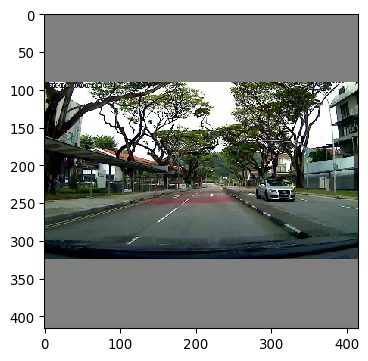

In [15]:
ia.imshow(iabox.draw_on_image(input_img[0]))

In [48]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].label)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.label[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].label[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if boxes[index_i].iou(boxes[index_j]) >= nms_thresh:
                    boxes[index_j].label[c] = 0

In [49]:
do_nms(iabox.bounding_boxes, 0.5)

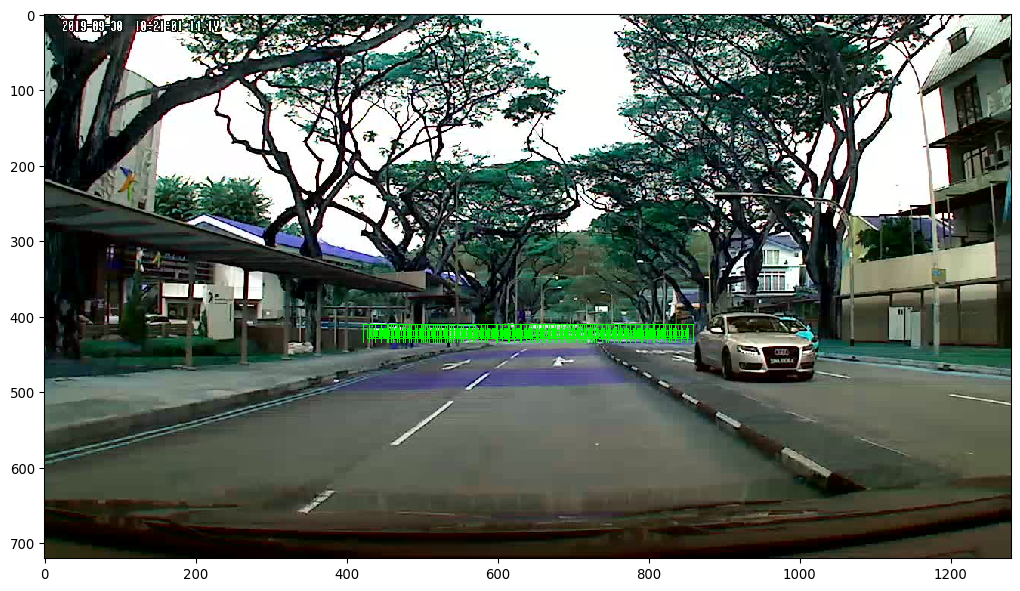

In [50]:
ia.imshow(iabox.draw_on_image(img))

In [9]:
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.engine.topology import Layer
import tensorflow as tf

In [10]:
class YoloLayer(Layer):
    def __init__(self, anchors, max_grid, batch_size, warmup_batches, ignore_thresh, 
                    grid_scale, obj_scale, noobj_scale, xywh_scale, class_scale, 
                    **kwargs):
        # make the model settings persistent
        self.ignore_thresh  = ignore_thresh
        self.warmup_batches = warmup_batches
        self.anchors        = tf.constant(anchors, dtype='float', shape=[1,1,1,3,2])
        self.grid_scale     = grid_scale
        self.obj_scale      = obj_scale
        self.noobj_scale    = noobj_scale
        self.xywh_scale     = xywh_scale
        self.class_scale    = class_scale        

        # make a persistent mesh grid
        max_grid_h, max_grid_w = max_grid

        cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(max_grid_w), [max_grid_h]), (1, max_grid_h, max_grid_w, 1, 1)))
        cell_y = tf.transpose(cell_x, (0,2,1,3,4))
        self.cell_grid = tf.tile(tf.concat([cell_x,cell_y],-1), [batch_size, 1, 1, 3, 1])

        super(YoloLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(YoloLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        input_image, y_pred, y_true, true_boxes = x

        # adjust the shape of the y_predict [batch, grid_h, grid_w, 3, 4+1+nb_class]
        y_pred = tf.reshape(y_pred, tf.concat([tf.shape(y_pred)[:3], tf.constant([3, -1])], axis=0))
        
        # initialize the masks
        object_mask     = tf.expand_dims(y_true[..., 4], 4)

        # the variable to keep track of number of batches processed
        batch_seen = tf.Variable(0.)        

        # compute grid factor and net factor
        grid_h      = tf.shape(y_true)[1]
        grid_w      = tf.shape(y_true)[2]
        grid_factor = tf.reshape(tf.cast([grid_w, grid_h], tf.float32), [1,1,1,1,2])

        net_h       = tf.shape(input_image)[1]
        net_w       = tf.shape(input_image)[2]            
        net_factor  = tf.reshape(tf.cast([net_w, net_h], tf.float32), [1,1,1,1,2])
        
        """
        Adjust prediction
        """
        pred_box_xy    = (self.cell_grid[:,:grid_h,:grid_w,:,:] + tf.sigmoid(y_pred[..., :2]))  # sigma(t_xy) + c_xy
        pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
        pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
        pred_box_class = y_pred[..., 5:]                                                        # adjust class probabilities      

        """
        Adjust ground truth
        """
        true_box_xy    = y_true[..., 0:2] # (sigma(t_xy) + c_xy)
        true_box_wh    = y_true[..., 2:4] # t_wh
        true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
        true_box_class = tf.argmax(y_true[..., 5:], -1)         

        """
        Compare each predicted box to all true boxes
        """        
        # initially, drag all objectness of all boxes to 0
        conf_delta  = pred_box_conf - 0 

        # then, ignore the boxes which have good overlap with some true box
        true_xy = true_boxes[..., 0:2] / grid_factor
        true_wh = true_boxes[..., 2:4] / net_factor
        
        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half
        
        pred_xy = tf.expand_dims(pred_box_xy / grid_factor, 4)
        pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * self.anchors / net_factor, 4)
        
        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half    

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)

        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        best_ious   = tf.reduce_max(iou_scores, axis=4)        
        conf_delta *= tf.expand_dims(tf.to_float(best_ious < self.ignore_thresh), 4)

        """
        Compute some online statistics
        """            
        true_xy = true_box_xy / grid_factor
        true_wh = tf.exp(true_box_wh) * self.anchors / net_factor

        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half

        pred_xy = pred_box_xy / grid_factor
        pred_wh = tf.exp(pred_box_wh) * self.anchors / net_factor 
        
        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half      

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)
        iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)
        
        count       = tf.reduce_sum(object_mask)
        count_noobj = tf.reduce_sum(1 - object_mask)
        detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
        class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
        recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
        recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
        avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
        avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
        avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
        avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 

        """
        Warm-up training
        """
        batch_seen = tf.assign_add(batch_seen, 1.)
        
        true_box_xy, true_box_wh, xywh_mask = tf.cond(tf.less(batch_seen, self.warmup_batches+1), 
                              lambda: [true_box_xy + (0.5 + self.cell_grid[:,:grid_h,:grid_w,:,:]) * (1-object_mask), 
                                       true_box_wh + tf.zeros_like(true_box_wh) * (1-object_mask), 
                                       tf.ones_like(object_mask)],
                              lambda: [true_box_xy, 
                                       true_box_wh,
                                       object_mask])

        """
        Compare each true box to all anchor boxes
        """      
        wh_scale = tf.exp(true_box_wh) * self.anchors / net_factor
        wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

        xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * self.xywh_scale
        wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * self.xywh_scale
        conf_delta  = object_mask * (pred_box_conf-true_box_conf) * self.obj_scale + (1-object_mask) * conf_delta * self.noobj_scale
        class_delta = object_mask * \
                      tf.expand_dims(tf.nn.softmax_cross_entropy_with_logits_v2(labels=true_box_class, logits=pred_box_class), 4) * \
                      self.class_scale

        loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(1,5)))
        loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(1,5)))
        loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(1,5)))
        loss_class = tf.reduce_sum(class_delta,               list(range(1,5)))

        loss = loss_xy + loss_wh + loss_conf + loss_class

        loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
        loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
        loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
        loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
        loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
        loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
        loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
        loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                       tf.reduce_sum(loss_wh), 
                                       tf.reduce_sum(loss_conf), 
                                       tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000)   


        return loss*self.grid_scale

    def compute_output_shape(self, input_shape):
        return [(None, 1)]

def _conv_block(inp, convs, do_skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and do_skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # unlike tensorflow darknet prefer left and top paddings
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # unlike tensorflow darknet prefer left and top paddings
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True,
                   )(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if do_skip else x        

def create_yolov3_model(
    nb_class, 
    anchors, 
    max_box_per_image, 
    max_grid, 
    batch_size, 
    warmup_batches,
    ignore_thresh,
    grid_scales,
    obj_scale,
    noobj_scale,
    xywh_scale,
    class_scale
):
    input_image = Input(shape=(None, None, 3)) # net_h, net_w, 3
    true_boxes  = Input(shape=(1, 1, 1, max_box_per_image, 4))
    true_yolo_1 = Input(shape=(None, None, len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class
    true_yolo_2 = Input(shape=(None, None, len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class
    true_yolo_3 = Input(shape=(None, None, len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], do_skip=False)

    # Layer 80 => 82
    pred_yolo_1 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                             {'filter': (3*(5+nb_class)), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], do_skip=False)
    loss_yolo_1 = YoloLayer(anchors[12:], 
                            [1*num for num in max_grid], 
                            batch_size, 
                            warmup_batches, 
                            ignore_thresh, 
                            grid_scales[0],
                            obj_scale,
                            noobj_scale,
                            xywh_scale,
                            class_scale)([input_image, pred_yolo_1, true_yolo_1, true_boxes])

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], do_skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], do_skip=False)

    # Layer 92 => 94
    pred_yolo_2 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                             {'filter': (3*(5+nb_class)), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], do_skip=False)
    loss_yolo_2 = YoloLayer(anchors[6:12], 
                            [2*num for num in max_grid], 
                            batch_size, 
                            warmup_batches, 
                            ignore_thresh, 
                            grid_scales[1],
                            obj_scale,
                            noobj_scale,
                            xywh_scale,
                            class_scale)([input_image, pred_yolo_2, true_yolo_2, true_boxes])

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], do_skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    pred_yolo_3 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                             {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                             {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                             {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                             {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                             {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                             {'filter': (3*(5+nb_class)), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], do_skip=False)
    loss_yolo_3 = YoloLayer(anchors[:6], 
                            [4*num for num in max_grid], 
                            batch_size, 
                            warmup_batches, 
                            ignore_thresh, 
                            grid_scales[2],
                            obj_scale,
                            noobj_scale,
                            xywh_scale,
                            class_scale)([input_image, pred_yolo_3, true_yolo_3, true_boxes]) 

    train_model = Model([input_image, true_boxes, true_yolo_1, true_yolo_2, true_yolo_3], [loss_yolo_1, loss_yolo_2, loss_yolo_3])
    infer_model = Model(input_image, [pred_yolo_1, pred_yolo_2, pred_yolo_3])

    return [train_model, infer_model]

def dummy_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(y_pred))

In [14]:
tm, im = create_yolov3_model(
3, yoloAPI.anchor_boxes, 3, [416,416], 2, 3, 0.5, [1,1,1], 5, 1, 1, 1)

In [15]:
tm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_11[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
__________________________________________________________________________________________________
zero_paddi